### Python code for Unsupervised Anomaly Detection for Financial Fraud: Integrating Traditional and Network-Based Features

####  Import Libraries and Load Data

In [2]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, average_precision_score

# Algorithms
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Network Analysis
import networkx as nx

# System
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
print("Libraries imported successfully!")

Libraries imported successfully!


#### Load and Explore Data

In [3]:
# Load the dataset
file_path = r"C:\Users\user\Desktop\Financial Dataset.csv" # Use your raw string path
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())
print("\nInfo:")
df.info()
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (1048575, 11)

Column Names:
 ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB

First 5 r

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Class Distribution (isFraud):
 isFraud
0    1047433
1       1142
Name: count, dtype: int64

Fraud Percentage: 0.1089%


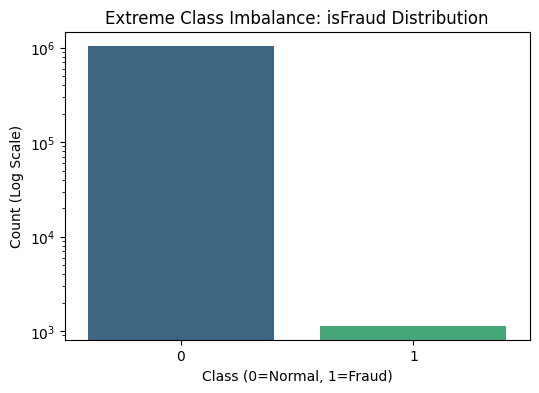

In [4]:
# Check for missing values and class distribution
print("Missing Values:\n", df.isnull().sum())
print("\nClass Distribution (isFraud):\n", df['isFraud'].value_counts())
print("\nFraud Percentage: {:.4f}%".format(df['isFraud'].mean() * 100))

# Plot the class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df, palette='viridis')
plt.title('Extreme Class Imbalance: isFraud Distribution')
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Count (Log Scale)')
plt.yscale('log') # Use log scale to make both classes visible
plt.show()

#### Exploratory Data Analysis (EDA)

=== EXPLORATORY DATA ANALYSIS (EDA) ===



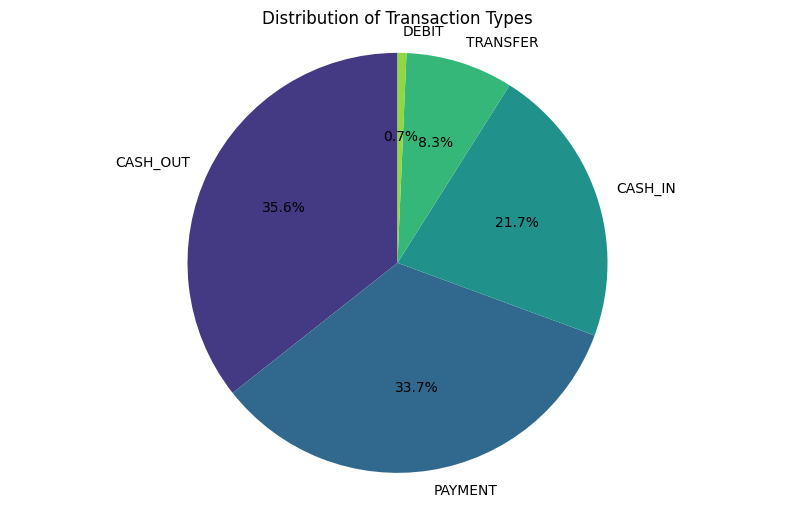


Fraud Analysis by Transaction Type:
           count  sum      mean  fraud_percentage
type                                             
TRANSFER   86753  564  0.006501          0.650122
CASH_OUT  373641  578  0.001547          0.154694
CASH_IN   227130    0  0.000000          0.000000
DEBIT       7178    0  0.000000          0.000000
PAYMENT   353873    0  0.000000          0.000000


In [7]:
# Exploratory Data Analysis (EDA)
print("=== EXPLORATORY DATA ANALYSIS (EDA) ===\n")

# 1. Distribution of Transaction Types
plt.figure(figsize=(10, 6))
type_counts = df['type'].value_counts()
colors = sns.color_palette('viridis', len(type_counts))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribution of Transaction Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Analyze fraud rate per transaction type
fraud_by_type = df.groupby('type')['isFraud'].agg(['count', 'sum', 'mean'])
fraud_by_type['fraud_percentage'] = fraud_by_type['mean'] * 100
fraud_by_type = fraud_by_type.sort_values('fraud_percentage', ascending=False)
print("\nFraud Analysis by Transaction Type:")
print(fraud_by_type)

#### Distribution of Transaction Amount (Log Scale)

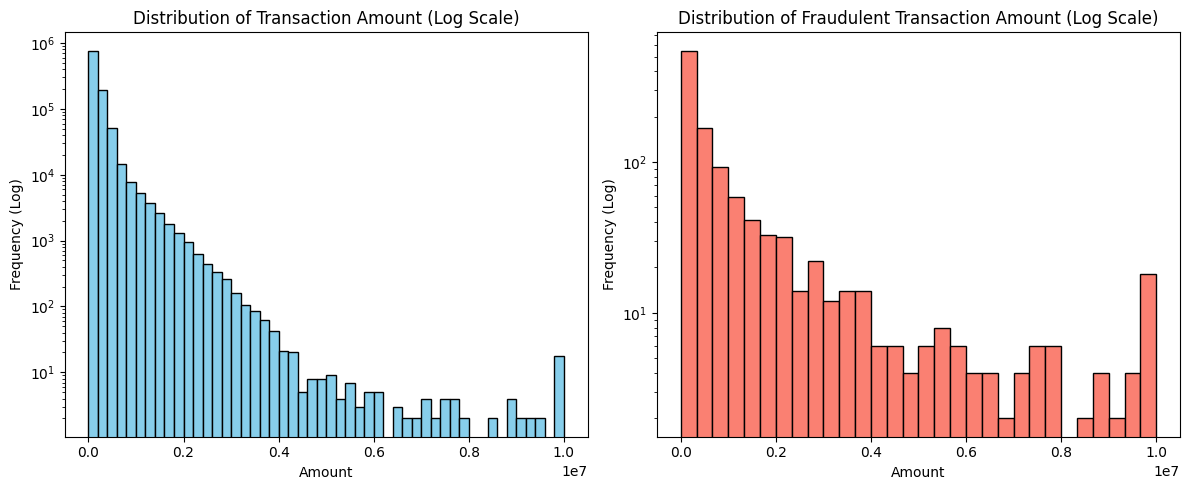


Transaction Amount Statistics:
Overall - Mean: 158666.98, Std: 264940.93, Max: 10000000.0
Fraud   - Mean: 1192628.93, Std: 2030598.96


In [8]:
# 2. Distribution of Transaction Amount (Log Scale)
plt.figure(figsize=(12, 5))

# Plot for all transactions
plt.subplot(1, 2, 1)
plt.hist(df['amount'], bins=50, color='skyblue', edgecolor='black', log=True)
plt.title('Distribution of Transaction Amount (Log Scale)')
plt.xlabel('Amount')
plt.ylabel('Frequency (Log)')

# Plot for fraudulent transactions only
plt.subplot(1, 2, 2)
plt.hist(df[df['isFraud']==1]['amount'], bins=30, color='salmon', edgecolor='black', log=True)
plt.title('Distribution of Fraudulent Transaction Amount (Log Scale)')
plt.xlabel('Amount')
plt.ylabel('Frequency (Log)')

plt.tight_layout()
plt.show()

# Print statistics
print("\nTransaction Amount Statistics:")
print(f"Overall - Mean: {df['amount'].mean():.2f}, Std: {df['amount'].std():.2f}, Max: {df['amount'].max()}")
print(f"Fraud   - Mean: {df[df['isFraud']==1]['amount'].mean():.2f}, Std: {df[df['isFraud']==1]['amount'].std():.2f}")

#### Time Analysis (Step Feature)

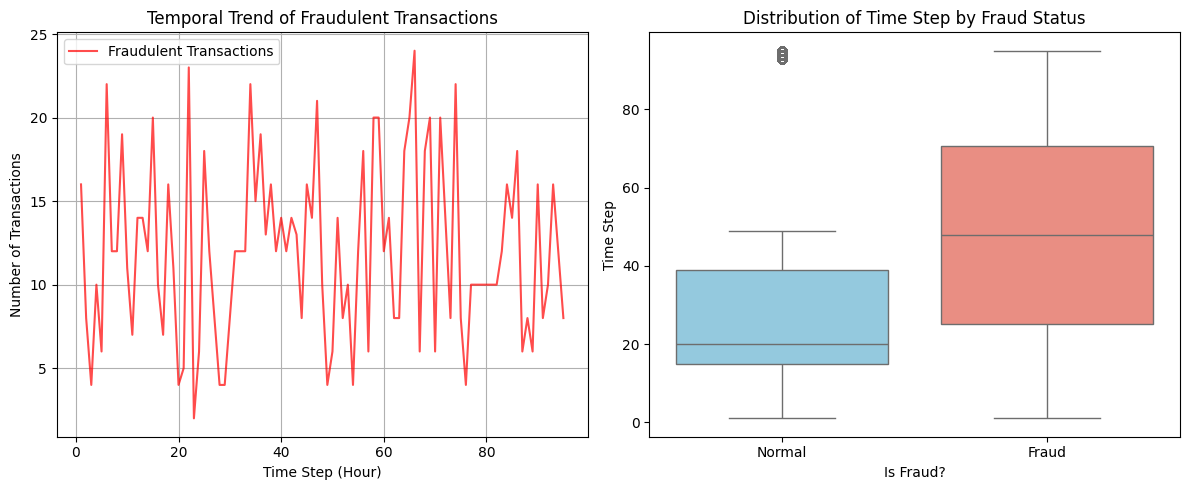

In [10]:
# 3. Time Analysis (Step feature)
plt.figure(figsize=(12, 5))

# Fraud over time (step)
fraud_over_time = df[df['isFraud']==1].groupby('step').size()
normal_over_time = df[df['isFraud']==0].groupby('step').size()

plt.subplot(1, 2, 1)
fraud_over_time.plot(kind='line', color='red', label='Fraudulent Transactions', alpha=0.7)
plt.title('Temporal Trend of Fraudulent Transactions')
plt.xlabel('Time Step (Hour)')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True)

# Boxplot of step by fraud status
plt.subplot(1, 2, 2)
# Convert the 'isFraud' column to string for categorical plotting
df['isFraud_str'] = df['isFraud'].astype(str)
sns.boxplot(x='isFraud_str', y='step', data=df, palette={'0': "skyblue", '1': "salmon"})
plt.title('Distribution of Time Step by Fraud Status')
plt.xlabel('Is Fraud?')
plt.ylabel('Time Step')
plt.xticks([0, 1], ['Normal', 'Fraud'])

plt.tight_layout()
plt.show()

#### Balanace Analysis: Old Balanc vs, New Balance for Origin Accounts

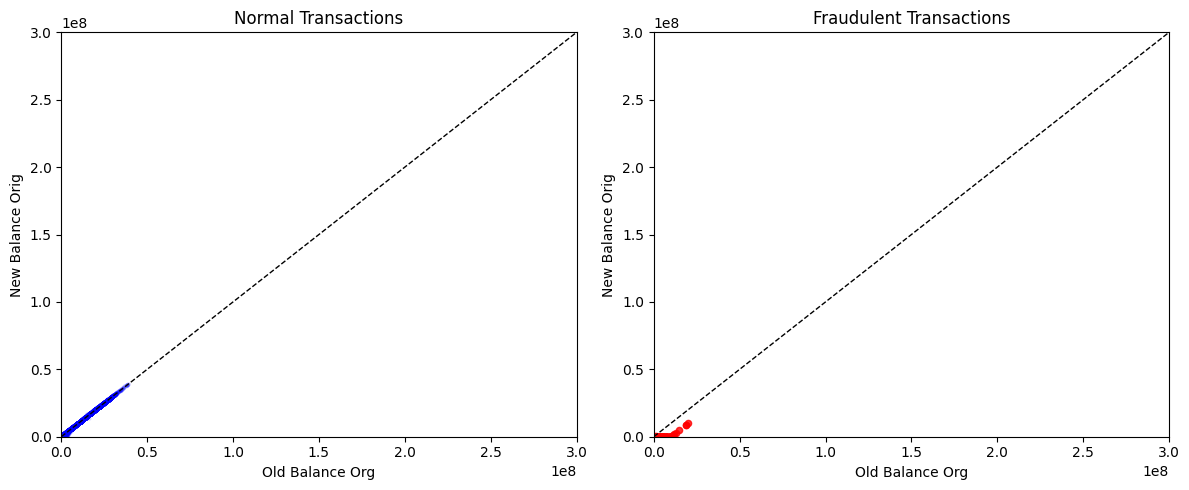

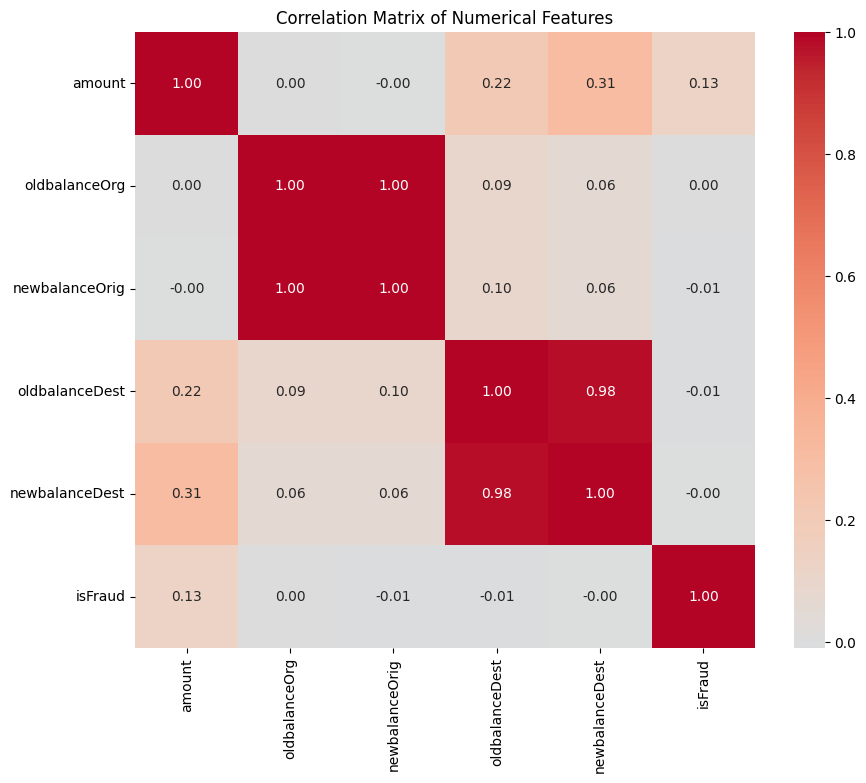

In [12]:
# 4. Balance Analysis: Old Balance vs New Balance for Origin Accounts
plt.figure(figsize=(12, 5))
# Plot for Normal transactions
plt.subplot(1, 2, 1)
plt.scatter(df[df['isFraud']==0]['oldbalanceOrg'], df[df['isFraud']==0]['newbalanceOrig'],
            alpha=0.1, c='blue', label='Normal', s=5)
plt.xlabel('Old Balance Org')
plt.ylabel('New Balance Orig')
plt.title('Normal Transactions')
plt.xlim(0, 3e8) # Limit axes to see the majority of points
plt.ylim(0, 3e8)
plt.plot([0, 3e8], [0, 3e8], 'k--', linewidth=1) # Add line y=x

# Plot for Fraudulent transactions
plt.subplot(1, 2, 2)
plt.scatter(df[df['isFraud']==1]['oldbalanceOrg'], df[df['isFraud']==1]['newbalanceOrig'],
            alpha=0.8, c='red', label='Fraud', s=20)
plt.xlabel('Old Balance Org')
plt.ylabel('New Balance Orig')
plt.title('Fraudulent Transactions')
plt.xlim(0, 3e8)
plt.ylim(0, 3e8)
plt.plot([0, 3e8], [0, 3e8], 'k--', linewidth=1) # Add line y=x

plt.tight_layout()
plt.show()

# 5. Correlation Heatmap (for numerical features)
plt.figure(figsize=(10, 8))
# Select numerical features for correlation
num_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
corr_matrix = df[num_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### Analysis of the Engineered Feature: errorBalanceOrig

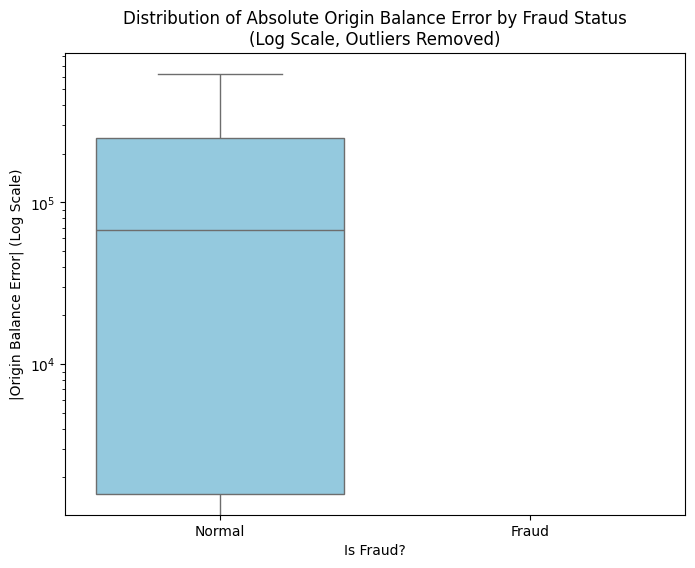


Balance Error Statistics (Absolute Value):
Normal Transactions:
count    1.047433e+06
mean     1.786524e+05
std      2.813218e+05
min      0.000000e+00
25%      1.580740e+03
50%      6.782852e+04
75%      2.510450e+05
max      6.388051e+06
Name: abs_error_orig, dtype: float64

Fraudulent Transactions:
count    1.142000e+03
mean     8.058776e+03
std      8.544826e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.933921e+06
Name: abs_error_orig, dtype: float64


In [14]:
# 6. Analysis of the Engineered Feature: errorBalanceOrig
plt.figure(figsize=(8, 6))
# We will look at the absolute error for visualization
df['abs_error_orig'] = np.abs(df['errorBalanceOrig'])
# Use a log scale on the y-axis due to extreme skewness

# Convert isFraud to string for proper palette mapping
df['isFraud_str'] = df['isFraud'].astype(str)
sns.boxplot(x='isFraud_str', y='abs_error_orig', data=df, showfliers=False, palette={'0': "skyblue", '1': "salmon"})
plt.yscale('log') # Critical to see the difference
plt.title('Distribution of Absolute Origin Balance Error by Fraud Status\n(Log Scale, Outliers Removed)')
plt.xlabel('Is Fraud?')
plt.ylabel('|Origin Balance Error| (Log Scale)')
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.show()

# Print statistics for the error
print("\nBalance Error Statistics (Absolute Value):")
print("Normal Transactions:")
print(df[df['isFraud']==0]['abs_error_orig'].describe())
print("\nFraudulent Transactions:")
print(df[df['isFraud']==1]['abs_error_orig'].describe())

#### Feature Engineering (Traditional)

In [5]:
# 1. One-Hot Encode the 'type' column
encoder = OneHotEncoder(drop='first', sparse_output=False) # Drop first to avoid multicollinearity
type_encoded = encoder.fit_transform(df[['type']])
type_encoded_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']))

# 2. Create error balance features
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# 3. Select features for the baseline model
baseline_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']
X_baseline = pd.concat([df[baseline_features], type_encoded_df], axis=1)
y = df['isFraud'].values

print("Baseline Feature DataFrame Shape:", X_baseline.shape)
X_baseline.head()

Baseline Feature DataFrame Shape: (1048575, 11)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,0.0,9839.64,0.0,0.0,1.0,0.0
1,1864.28,21249.0,19384.72,0.0,0.0,0.0,1864.28,0.0,0.0,1.0,0.0
2,181.00,181.0,0.00,0.0,0.0,0.0,181.00,0.0,0.0,0.0,1.0
3,181.00,181.0,0.00,21182.0,0.0,0.0,21363.00,1.0,0.0,0.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0,0.0,11668.14,0.0,0.0,1.0,0.0


#### Network Feature Engineering

In [6]:
# Create a sample of the data for graph building (e.g., 20% for demonstration)
sample_df = df.sample(frac=0.2, random_state=42)

print("Building transaction graph from sample...")
G = nx.DiGraph() # Directed Graph

# Add edges (transactions) to the graph
for _, row in sample_df.iterrows():
    G.add_edge(row['nameOrig'], row['nameDest'], amount=row['amount'], step=row['step'])

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Calculate centrality measures for nodes in the graph (This can take time)
print("Calculating centrality measures...")
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, k=1000) # k: use a subset of nodes for approximation
pagerank = nx.pagerank(G)

# Create a dictionary to map customer ID to its network features
network_features_dict = {}
for node in G.nodes():
    network_features_dict[node] = {
        'degree_centrality': degree_centrality.get(node, 0),
        'betweenness_centrality': betweenness_centrality.get(node, 0),
        'pagerank': pagerank.get(node, 0)
    }

# Map these features back to the original FULL dataframe for origin and destination customers
print("Mapping network features back to main dataframe...")
df['orig_degree'] = df['nameOrig'].map(lambda x: network_features_dict.get(x, {}).get('degree_centrality', 0))
df['orig_betweenness'] = df['nameOrig'].map(lambda x: network_features_dict.get(x, {}).get('betweenness_centrality', 0))
df['orig_pagerank'] = df['nameOrig'].map(lambda x: network_features_dict.get(x, {}).get('pagerank', 0))

df['dest_degree'] = df['nameDest'].map(lambda x: network_features_dict.get(x, {}).get('degree_centrality', 0))
df['dest_betweenness'] = df['nameDest'].map(lambda x: network_features_dict.get(x, {}).get('betweenness_centrality', 0))
df['dest_pagerank'] = df['nameDest'].map(lambda x: network_features_dict.get(x, {}).get('pagerank', 0))

# Create the enhanced feature set
network_feature_columns = ['orig_degree', 'orig_betweenness', 'orig_pagerank', 'dest_degree', 'dest_betweenness', 'dest_pagerank']
X_enhanced = pd.concat([X_baseline, df[network_feature_columns]], axis=1)

print("Enhanced Feature DataFrame Shape:", X_enhanced.shape)
X_enhanced.head()

Building transaction graph from sample...
Graph built with 339805 nodes and 209715 edges.
Calculating centrality measures...
Mapping network features back to main dataframe...
Enhanced Feature DataFrame Shape: (1048575, 17)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,orig_degree,orig_betweenness,orig_pagerank,dest_degree,dest_betweenness,dest_pagerank
0,9839.64,170136.0,160296.36,0.0,0.0,0.0,9839.64,0.0,0.0,1.0,0.0,0.000003,0.0,0.000002,0.000003,0.0,0.000003
1,1864.28,21249.0,19384.72,0.0,0.0,0.0,1864.28,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,181.00,181.0,0.00,0.0,0.0,0.0,181.00,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.000012,0.0,0.000007
3,181.00,181.0,0.00,21182.0,0.0,0.0,21363.00,1.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000015,0.0,0.000008
4,11668.14,41554.0,29885.86,0.0,0.0,0.0,11668.14,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


#### Data Preprocessing & Split

In [15]:
# Scale the features
scaler_baseline = RobustScaler()
X_baseline_scaled = scaler_baseline.fit_transform(X_baseline)

scaler_enhanced = RobustScaler()
X_enhanced_scaled = scaler_enhanced.fit_transform(X_enhanced)

# Split the data: Use 80% for training (only normal transactions) and 20% for testing (all)
X_train_base, X_test_base, y_train, y_test = train_test_split(X_baseline_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train_enh, X_test_enh, _, _ = train_test_split(X_enhanced_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Create a pure training set of ONLY non-fraudulent transactions
X_train_base_normal = X_train_base[y_train == 0]
X_train_enh_normal = X_train_enh[y_train == 0]

print(f"Baseline Training (Normal only): {X_train_base_normal.shape}")
print(f"Enhanced Training (Normal only): {X_train_enh_normal.shape}")
print(f"Test Set (Contains Fraud): {X_test_base.shape}")

Baseline Training (Normal only): (837946, 11)
Enhanced Training (Normal only): (837946, 17)
Test Set (Contains Fraud): (209715, 11)


#### Model 1: Isolation Forest

Training Isolation Forest on Enhanced Features...

--- ISOLATION FOREST RESULTS ---

Baseline Features Performance:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    209487
       Fraud       0.00      0.01      0.00       228

    accuracy                           1.00    209715
   macro avg       0.50      0.50      0.50    209715
weighted avg       1.00      1.00      1.00    209715

AUPRC: 0.0040

Enhanced Features Performance:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    209487
       Fraud       0.00      0.00      0.00       228

    accuracy                           1.00    209715
   macro avg       0.50      0.50      0.50    209715
weighted avg       1.00      1.00      1.00    209715

AUPRC: 0.0035


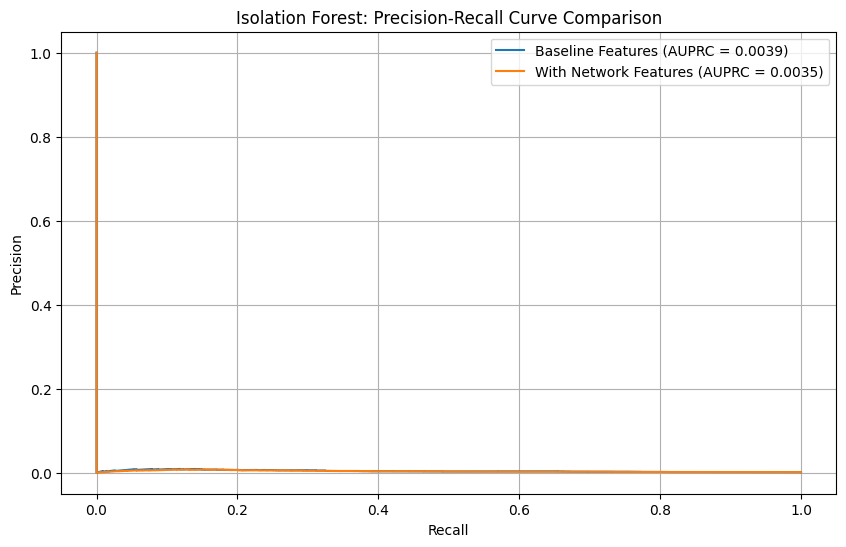

In [17]:
# Run on Enhanced Features
print("Training Isolation Forest on Enhanced Features...")
scores_enh_if, preds_enh_if = run_isolation_forest(X_train_enh_normal, X_test_enh, y_test)

# Evaluate and Compare
print("\n--- ISOLATION FOREST RESULTS ---")
print("\nBaseline Features Performance:")
print(classification_report(y_test, preds_base_if, target_names=['Normal', 'Fraud']))
print(f"AUPRC: {average_precision_score(y_test, scores_base_if):.4f}")

print("\nEnhanced Features Performance:")
print(classification_report(y_test, preds_enh_if, target_names=['Normal', 'Fraud']))
print(f"AUPRC: {average_precision_score(y_test, scores_enh_if):.4f}")  # CORRECTED: Changed scores_enh_ae to scores_enh_if

# Plot PR Curves for comparison
plt.figure(figsize=(10, 6))
precision, recall, _ = precision_recall_curve(y_test, scores_base_if)
plt.plot(recall, precision, label=f'Baseline Features (AUPRC = {auc(recall, precision):.4f})')

precision, recall, _ = precision_recall_curve(y_test, scores_enh_if)  # CORRECTED: Changed scores_enh_ae to scores_enh_if
plt.plot(recall, precision, label=f'With Network Features (AUPRC = {auc(recall, precision):.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Isolation Forest: Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

#### Model 2: Autoencoder

Training Autoencoder on Baseline Features...
Training Autoencoder on Enhanced Features...

--- AUTOENCODER RESULTS ---

Baseline Features Performance:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    209487
       Fraud       0.05      0.22      0.08       228

    accuracy                           0.99    209715
   macro avg       0.52      0.61      0.54    209715
weighted avg       1.00      0.99      1.00    209715

AUPRC: 0.0827

Enhanced Features Performance:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    209487
       Fraud       0.08      0.21      0.11       228

    accuracy                           1.00    209715
   macro avg       0.54      0.61      0.55    209715
weighted avg       1.00      1.00      1.00    209715

AUPRC: 0.1112


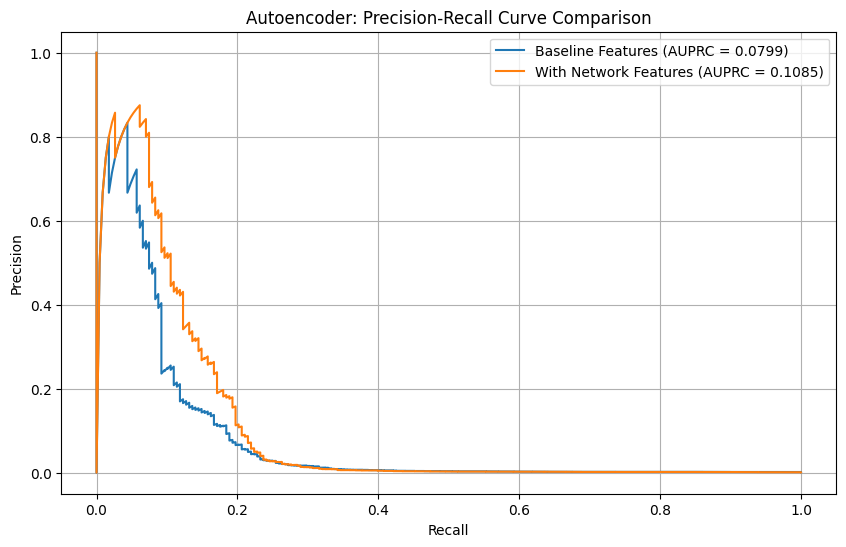

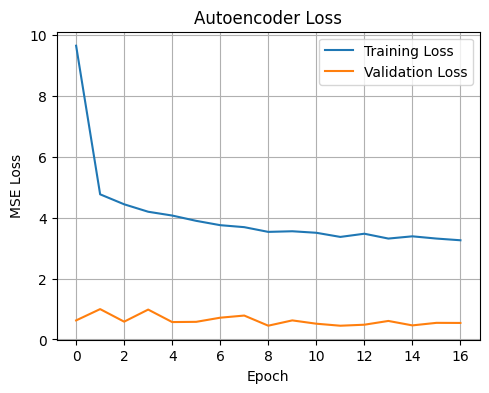

In [18]:
# Function to build, train, and evaluate an Autoencoder
def run_autoencoder(X_train_normal, X_test, y_test, encoding_dim=10, epochs=50):
    input_dim = X_train_normal.shape[1]
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoder = Dense(encoding_dim * 2, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.2)(encoder)
    encoder = Dense(encoding_dim, activation='relu')(encoder)
    
    # Decoder
    decoder = Dense(encoding_dim * 2, activation='relu')(encoder)
    decoder = Dropout(0.2)(decoder)
    decoder = Dense(input_dim, activation='linear')(decoder)
    
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Callbacks
    callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)]
    
    # Train (use a validation split of normal data)
    history = autoencoder.fit(X_train_normal, X_train_normal,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=callbacks,
                    verbose=0).history
    # Predict and get MSE reconstruction error
    X_pred = autoencoder.predict(X_test, verbose=0)
    mse = np.mean(np.power(X_test - X_pred, 2), axis=1)
    return mse, history

# Run on Baseline Features
print("Training Autoencoder on Baseline Features...")
scores_base_ae, history_base = run_autoencoder(X_train_base_normal, X_test_base, y_test)

# Run on Enhanced Features
print("Training Autoencoder on Enhanced Features...")
scores_enh_ae, history_enh = run_autoencoder(X_train_enh_normal, X_test_enh, y_test)

# Find threshold (e.g., 99th percentile of training reconstruction error)
threshold_base = np.percentile(history_base['loss'], 99) # Use final training loss distribution
threshold_enh = np.percentile(history_enh['loss'], 99)

preds_base_ae = (scores_base_ae > threshold_base).astype(int)
preds_enh_ae = (scores_enh_ae > threshold_enh).astype(int)

# Evaluate and Compare
print("\n--- AUTOENCODER RESULTS ---")
print("\nBaseline Features Performance:")
print(classification_report(y_test, preds_base_ae, target_names=['Normal', 'Fraud']))
print(f"AUPRC: {average_precision_score(y_test, scores_base_ae):.4f}")

print("\nEnhanced Features Performance:")
print(classification_report(y_test, preds_enh_ae, target_names=['Normal', 'Fraud']))
print(f"AUPRC: {average_precision_score(y_test, scores_enh_ae):.4f}")

# Plot PR Curves for comparison
plt.figure(figsize=(10, 6))
precision, recall, _ = precision_recall_curve(y_test, scores_base_ae)
plt.plot(recall, precision, label=f'Baseline Features (AUPRC = {auc(recall, precision):.4f})')

precision, recall, _ = precision_recall_curve(y_test, scores_enh_ae)
plt.plot(recall, precision, label=f'With Network Features (AUPRC = {auc(recall, precision):.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Autoencoder: Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history for the enhanced model (optional but insightful)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_enh['loss'], label='Training Loss')
plt.plot(history_enh['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

### 